<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/01_GNN_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks for Molecular Representation: Tutorial

## Table of Contents
1. [Setup and Installation](#setup-and-installation)
2. [Introduction](#introduction)
3. [Theoretical Background: Molecules as Graphs](#theoretical-background-molecules-as-graphs)
4. [Implementing Molecular Graph Representations](#implementing-molecular-graph-representations)
5. [PyTorch Geometric for Molecular Graphs](#pytorch-geometric-for-molecular-graphs)
6. [Working with Molecular Datasets](#working-with-molecular-datasets)
7. [Visualizing Molecular Graphs](#visualizing-molecular-graphs)

## Setup and Installation <a name="setup-and-installation"></a>

First, we'll install the required libraries. We'll need:
- **RDKit**: For molecular manipulation and cheminformatics
- **PyTorch Geometric**: For graph neural network implementations
- **Matplotlib & Seaborn**: For visualization

In [1]:
#@title install required libraries
!pip install -q rdkit
!pip install -q myst_nb
!pip install -q torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.3 MB/s eta 0:00:00


Now let's import the libraries we'll need throughout this tutorial:


In [3]:
#@title Import required libraries
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit for molecular handling
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

# NetworkX for graph visualization
import networkx as nx

# Set plotting style
sns.set_context("notebook", font_scale=1.5)
sns.set_palette("Set2")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Introduction <a name="introduction"></a>
Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.

GNNs are specific layers that input a graph and output a graph. You can find reviews of GNNs in Dwivedi *et al.*{cite}`dwivedi2020benchmarking`, Bronstein *et al.*{cite}`bronstein2017geometric`, and  Wu *et al.*{cite}`wu2020comprehensive`. GNNs can be used for everything from coarse-grained molecular dynamics {cite}`li2020graph` to predicting NMR chemical shifts {cite}`yang2020predicting` to modeling dynamics of solids {cite}`xie2019graph`. Before we dive too deep into them, we must first understand how a graph is represented in a computer and how molecules are converted into graphs.

You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/) {cite}`sanchez-lengeling2021a`. Most current research in GNNs is done with specialized deep learning libraries for graphs. The most common are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), [Deep Graph library](https://www.dgl.ai/), [DIG](https://github.com/divelab/DIG), [Spektral](https://graphneural.network/), and [TensorFlow GNNS](https://github.com/tensorflow/gnn).


### Learning Objectives

By the end of this tutorial, you will be able to:
- **Understand** the theoretical foundations of graph representations for molecules
- **Implement** conversion from molecular structures to graph data structures
- **Distinguish** between graph, node, and edge features and their chemical significance
- **Work with** PyTorch Geometric for molecular graph manipulation
- **Visualize** molecular graphs and their learned representations




## Theoretical Background: Molecules as Graphs <a name="theoretical-background-molecules-as-graphs"></a>


### What is a Graph?

A graph G is defined by a set of nodes (vertices) V and edges E. In the context of molecules:
- **Nodes** represent atoms
- **Edges** represent bonds between atoms

Mathematically, we can represent a graph in several ways:
1. **Adjacency Matrix**: A matrix E where e_ij = 1 if nodes i and j are connected
2. **Node Feature Matrix**: A matrix V where each row represents the features of a node
3. **Edge Feature Matrix**: A tensor where each entry e_ij represents features of the connection between nodes i and j

### Representing Molecules as Graphs

Let's consider a simple molecule: methanol (CH₃OH).


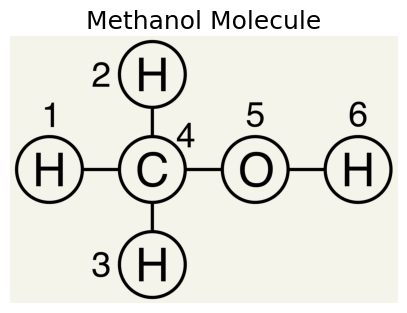

In [4]:
# Download methanol image for visualization
!wget -q https://github.com/whitead/dmol-book/blob/main/dl/methanol.jpg?raw=true -O methanol.jpg

# Display the molecule
from PIL import Image
img = Image.open('methanol.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Methanol Molecule')
plt.show()

Let's see how a graph can be constructed from a molecule. Consider methanol, shown in the figure.

When representing methanol as a graph:
1. We have 6 nodes (atoms): 1 carbon (C), 1 oxygen (O), and 4 hydrogens (H)
2. We have 5 edges (bonds): C-O and four C-H bonds


#### Node Features

For each atom (node), we need to define a feature vector. Commonly used atom features include:
- **Atom type** (usually one-hot encoded)
- **Formal charge**
- **Hybridization state**
- **Aromaticity**
- **Number of connected hydrogens**

For simplicity, let's start with just atom type using one-hot encoding:





In [12]:
# Define a simple mapping of atoms to indices
atom_mapping = {'H': 0, 'O': 1, 'C': 2}

# Let's visualize the node feature matrix for methanol
# Atom order:  H, H, H, C, O, H
node_features = np.zeros((6, 3))  # 6 atoms, 3 possible atom types
node_features[0, 0] = 1  # H
node_features[1, 0] = 1  # H
node_features[2, 0] = 1  # H
node_features[3, 2] = 1  # C
node_features[4, 1] = 1  # O
node_features[5, 0] = 1  # H

print("Node Feature Matrix (Rows: Atoms, Columns: Atom Types):")
node_df = pd.DataFrame(node_features,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['H', 'O', 'C'])
display(node_df)

Node Feature Matrix (Rows: Atoms, Columns: Atom Types):


,H,O,C
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
5,0.0,1.0,0.0
6,1.0,0.0,0.0


#### Adjacency Matrix

The adjacency matrix represents which atoms are bonded to each other:

In [13]:
# Let's create the adjacency matrix for methanol
# Atom order: H, H, H, C, O, H (indexed from 0 to 5)
adjacency = np.zeros((6, 6))

# Define bonds: C-O and C-H bonds
bonds = [(0, 3),  # C-H1
         (1, 3),  # C-H2
         (2, 3),  # C-H3
         (3, 4),  # C-H4
         (4, 5)]  # O-H4

# Fill the adjacency matrix (undirected graph, so matrix is symmetric)
for i, j in bonds:
    adjacency[i, j] = 1
    adjacency[j, i] = 1  # Symmetric because bonds are undirected

print("Adjacency Matrix (1 indicates a bond between atoms):")
adj_df = pd.DataFrame(adjacency,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['1', '2', '3', '4', '5', '6'])
display(adj_df)

Adjacency Matrix (1 indicates a bond between atoms):


,1,2,3,4,5,6
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0


#### Edge Features

We can also define features for each bond (edge), such as:
- **Bond type** (single, double, triple, aromatic)
- **Bond length**
- **Bond angle**

For simplicity, we'll just use bond type as a feature:

In [15]:
# Create an edge feature tensor for methanol
# We'll use one-hot encoding for bond types: [single, double, triple, aromatic]
num_bonds = len(bonds)
edge_features = np.zeros((num_bonds, 4))  # 5 bonds, 4 possible bond types

# All bonds in methanol are single bonds (index 0)
edge_features[:, 0] = 1

print("Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):")
edge_df = pd.DataFrame(edge_features,
                      index=['C-H1', 'C-H2', 'C-H3', 'C-O', 'O-H4'],
                      columns=['Single', 'Double', 'Triple', 'Aromatic'])
display(edge_df)

Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):


,Single,Double,Triple,Aromatic
C-H1,1.0,0.0,0.0,0.0
C-H2,1.0,0.0,0.0,0.0
C-H3,1.0,0.0,0.0,0.0
C-O,1.0,0.0,0.0,0.0
O-H4,1.0,0.0,0.0,0.0


### Visualizing the Graph Representation

Let's visualize the methanol molecule as a graph:

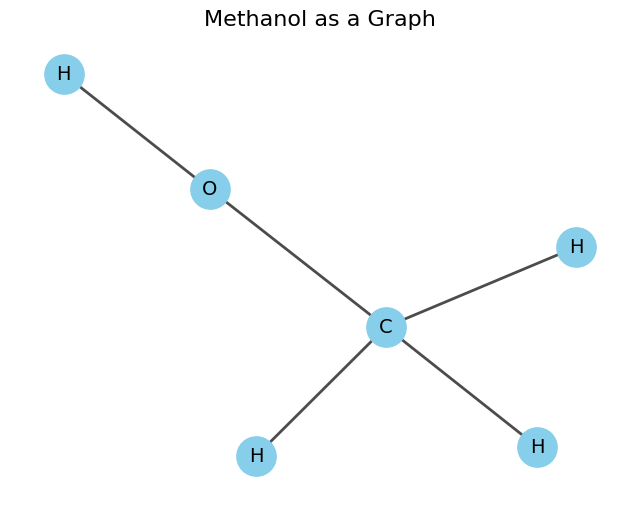

In [18]:
def visualize_molecular_graph(adjacency, node_labels):
    """Visualize a molecule as a graph."""
    G = nx.Graph()

    # Add nodes
    for i, label in enumerate(node_labels):
        G.add_node(i, label=label)

    # Add edges
    rows, cols = np.where(adjacency == 1)
    edges = zip(rows.tolist(), cols.tolist())
    for i, j in edges:
        if i < j:  # Add each edge only once
            G.add_edge(i, j)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout

    # Draw nodes with labels
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(G, pos, labels={i: node_labels[i] for i in range(len(node_labels))}, font_size=14)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7)

    plt.axis('off')
    plt.title('Methanol as a Graph', fontsize=16)
    plt.show()

# Visualize methanol
atom_labels = [ 'H', 'H', 'H', 'C', 'O', 'H']
visualize_molecular_graph(adjacency, atom_labels)

### From Chemical Structure to Graph: The Complete Picture

Now let's put it all together to understand the flow from a chemical structure to a graph representation:

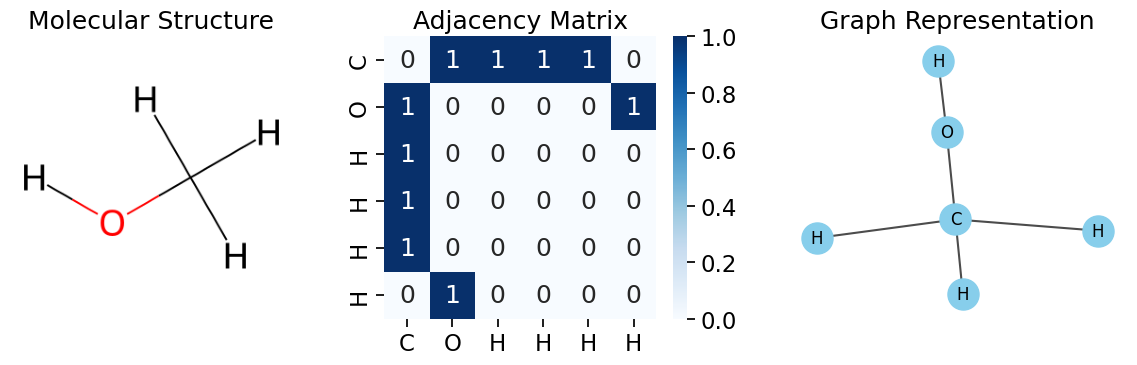

In [21]:
def show_molecule_to_graph_conversion(smiles):
    """Show the conversion from molecular structure to graph representation."""
    # Create RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens

    # Draw the molecule
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure')

    # Get atom and bond information
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    atom_indices = {a.GetIdx(): i for i, a in enumerate(mol.GetAtoms())}

    # Create adjacency matrix
    n_atoms = len(atoms)
    adj_matrix = np.zeros((n_atoms, n_atoms))

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1

    # Create node features (one-hot encoding of atom type)
    unique_atoms = sorted(set(atoms))
    atom_to_idx = {atom: i for i, atom in enumerate(unique_atoms)}

    node_features = np.zeros((n_atoms, len(unique_atoms)))
    for i, atom in enumerate(atoms):
        node_features[i, atom_to_idx[atom]] = 1

    # Visualize adjacency matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(adj_matrix, cmap='Blues', annot=True, fmt='.0f',
                xticklabels=atoms, yticklabels=atoms)
    plt.title('Adjacency Matrix')

    # Visualize the graph
    plt.subplot(1, 3, 3)
    G = nx.Graph()

    # Add nodes
    for i, atom in enumerate(atoms):
        G.add_node(i, label=atom)

    # Add edges
    rows, cols = np.where(adj_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    for i, j in edges:
        if i < j:  # Add each edge only once
            G.add_edge(i, j)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_labels(G, pos, labels={i: atoms[i] for i in range(len(atoms))}, font_size=12)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    plt.axis('off')
    plt.title('Graph Representation')

    plt.tight_layout()
    plt.show()

    return mol, adj_matrix, node_features, atoms

# Demonstrate with methanol
methanol_smiles = "CO"
mol, adj_matrix, node_features, atoms = show_molecule_to_graph_conversion(methanol_smiles)

### ✅ Checkpoint: Understanding Molecular Graphs

To reinforce your understanding, try answering these questions:

1. **Question**: What does each row in the node feature matrix represent?
   - **Answer**: Each row represents one atom in the molecule, with its features encoded.

2. **Question**: Why is the adjacency matrix symmetric for molecules?
   - **Answer**: Because chemical bonds are undirected (atoms are mutually bonded to each other).

3. **Question**: How would the graph representation change for a molecule with a double bond?
   - **Answer**: The edge feature for that bond would have a 1 in the position representing double bonds instead of single bonds.

## Implementing Molecular Graph Representations <a name="implementing-molecular-graph-representations"></a>

Now, let's create a function to convert any molecule (represented as a SMILES string) into a graph representation:

In [25]:
def smiles_to_graph(smiles):
    """
    Convert a SMILES string to graph representation.

    Args:
        smiles (str): SMILES string of the molecule

    Returns:
        tuple:
            - node_features (np.ndarray): Node feature matrix
            - adjacency (np.ndarray): Adjacency matrix
            - edge_features (np.ndarray): Edge feature matrix
    """
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Add hydrogens to make the representation complete
    mol = Chem.AddHs(mol)

    # Map bond types to indices
    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }

    # Get the number of atoms
    n_atoms = mol.GetNumAtoms()

    # Create node features
    # We'll use a simple one-hot encoding for atom types: C, O, N, H, and "other"
    elements = ["C", "O", "N", "H", "Other"]
    node_features = np.zeros((n_atoms, len(elements)))

    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        symbol = atom.GetSymbol()
        if symbol in elements:
            node_features[idx, elements.index(symbol)] = 1
        else:
            # Mark as "other" if not in our element list
            node_features[idx, -1] = 1

    # Create adjacency matrix and edge features
    adjacency = np.zeros((n_atoms, n_atoms))
    edge_features = []
    edge_indices = []

    for bond in mol.GetBonds():
        # Get the atoms in the bond
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()

        # Update adjacency matrix (symmetric)
        adjacency[begin_idx, end_idx] = 1
        adjacency[end_idx, begin_idx] = 1

        # Get bond type
        bond_type = bond.GetBondType()
        bond_feature = np.zeros(len(bond_type_to_idx))

        if bond_type in bond_type_to_idx:
            bond_feature[bond_type_to_idx[bond_type]] = 1
        else:
            print(f"Warning: Unknown bond type {bond_type}")

        # Add edge in both directions (undirected graph)
        edge_features.append(bond_feature)
        edge_indices.append((begin_idx, end_idx))

        edge_features.append(bond_feature)  # Same feature for the reverse direction
        edge_indices.append((end_idx, begin_idx))

    # Convert edge features to numpy array
    if edge_features:
        edge_features = np.array(edge_features)
    else:
        edge_features = np.empty((0, len(bond_type_to_idx)))

    return node_features, adjacency, edge_features, edge_indices

# Let's test our function on several molecules
molecules = {
    "Methanol": "CO",
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C)C(=O)N2C",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

# Test with methanol
methanol_features, methanol_adj, methanol_edge_features, methanol_edge_indices = smiles_to_graph(molecules["Methanol"])

print("Methanol Node Features:")
print(methanol_features)
print("\nMethanol Adjacency Matrix:")
print(methanol_adj)
print("\nMethanol Edge Features:")
print(methanol_edge_features)

Methanol Node Features:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]

Methanol Adjacency Matrix:
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]

Methanol Edge Features:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [ ]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = { 6: "C",  8: "O", 1: "H"}

The cell below defines our function `smiles2graph`. This creates one-hot node feature vectors for the element H, O, and C. It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [ ]:
def smiles2graph(sml):
    """Argument for the smiles2graph function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [ ]:
nodes, adj = smiles2graph("CO")
nodes
## number of rows are the number of atoms in the moelcule, and the number of columns are the features for each node

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
adjacancy = adj[:,:,0] + adj[:,:,1] + adj[:,:,2] + adj[:,:,3] + adj[:,:,4]
adjacancy

array([[0., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

### Exercise
1- Write code to create the adjacancy list for the ethanol molecule.

Now we want to show the methanol molecule with the features on top of each nodes (atoms)

  if event.key is 'enter':



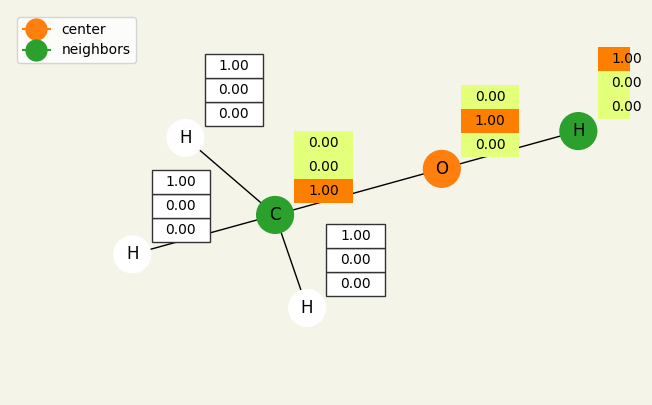

In [ ]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


def draw_vector(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        if cmap is not None:
            ax.add_patch(
                mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(vi), **kwargs)
            )
        else:
            ax.add_patch(
                mpl.patches.Rectangle(
                    (x, y), s * 1.5, s, facecolor="#FFF", edgecolor="#333", **kwargs
                )
            )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            "{:.2f}".format(vi),
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s


def draw_key(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        ax.add_patch(
            mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(1.0), **kwargs)
        )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            vi,
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s
    ax.text(
        x, y + s / 2, "Key:", verticalalignment="center", horizontalalignment="left"
    )


def draw(
    nodes, adj, ax, highlight=None, key=False, labels=None, mask=None, draw_nodes=None
):
    G = nx.Graph()
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if np.any(adj[i, j]):
                G.add_edge(i, j)
    if mask is None:
        mask = [True] * len(G)
    if draw_nodes is None:
        draw_nodes = nodes
    # go from atomic number to element
    elements = np.argmax(draw_nodes, axis=-1)
    el_labels = {i: list(my_elements.values())[e] for i, e in enumerate(elements)}
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")
    except ImportError:
        pos = nx.spring_layout(G, iterations=100, seed=4, k=1)
    pos = nx.rescale_layout_dict(pos)
    c = ["white"] * len(G)
    all_h = []
    if highlight is not None:
        for i, h in enumerate(highlight):
            for hj in h:
                c[hj] = "C{}".format(i + 1)
                all_h.append(hj)
    nx.draw(G, ax=ax, pos=pos, labels=el_labels, node_size=700, node_color=c)
    cmap = plt.get_cmap("Wistia")
    for i in range(len(G)):
        if not mask[i]:
            continue
        if i in all_h:
            draw_vector(*pos[i], 0.15, nodes[i], ax, cmap)
        else:
            draw_vector(*pos[i], 0.15, nodes[i], ax, None)
    if key:
        draw_key(-1, -1, 0.15, my_elements.values(), ax, cmap)
    if labels is not None:
        legend_elements = []
        for i, l in enumerate(labels):
            p = mpl.lines.Line2D(
                [0], [0], marker="o", color="C{}".format(i + 1), label=l, markersize=15
            )
            legend_elements.append(p)
        ax.legend(handles=legend_elements)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_facecolor("#f5f4e9")


fig = plt.figure(figsize=(8, 5))
draw(nodes, adj, plt.gca(), highlight=[[1], [5, 0]], labels=["center", "neighbors"])
fig.set_facecolor("#f5f4e9")
glue("dframe", plt.gcf(), display=False)

## PyTorch Geometric for Molecular Graphs

### How to create a graph in PyTorch Geometric

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

- data.x: Node feature matrix with shape [num_nodes, num_node_features]

- data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

- data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

- data.pos: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required. In fact, the Data object is not even restricted to these attributes. We can, e.g., extend it by data.face to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type torch.long.

In [ ]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


### Common Benchmark Datasets

In [ ]:
# Load the ESOL dataset
data = MoleculeNet(root='.', name='BACE')

# Print information about the dataset
print(f'Dataset: {data}:')
print('====================')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')

Processing...


Dataset: BACE(1513):
Number of graphs: 1513
Number of features: 9
Number of classes: 2


Done!


In [ ]:
# Get the first graph in the dataset
graph = data[0]

# Print information about the graph
print(graph)
print('=============================================================')

# Access graph attributes
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Node features:\n{graph.x}')
print(f'Edge index:\n{graph.edge_index}')
print(f'Edge attributes:\n{graph.edge_attr}')
print(f'Target: {graph.y}')

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])
Number of nodes: 32
Number of edges: 70
Node features:
tensor([[8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 1, 4, 5, 1, 0, 4, 0, 1],
        [7, 0, 3, 5, 1, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 1, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 3, 5, 2, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

  node_collection = ax.scatter(



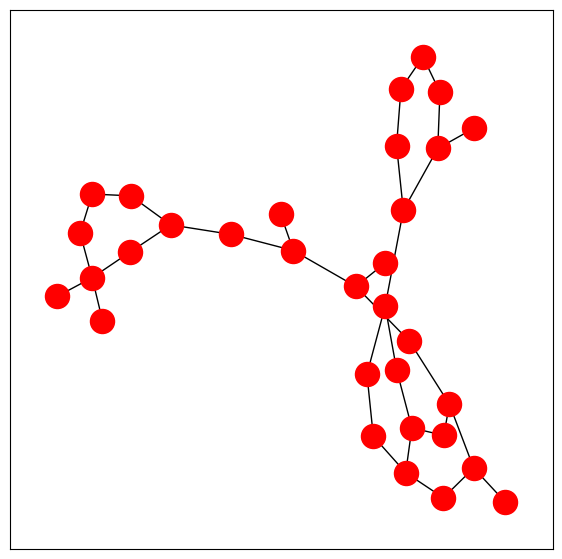

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(graph, to_undirected=True)
visualize_graph(G, color="red")

 Node features shape :  torch.Size([32, 9])
 Edge indices shape :  torch.Size([2, 70])
 Edge attributes shape :  torch.Size([70, 3])
 Target :  tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])


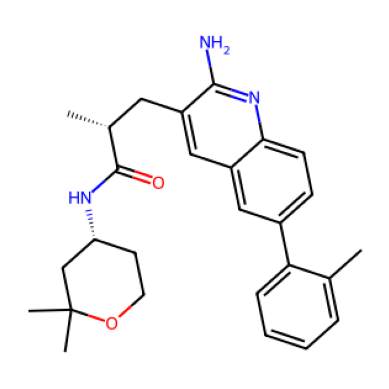

In [ ]:
# Explore a single molecule
print ( " Node features shape : " , graph.x .shape )
print ( " Edge indices shape : " , graph.edge_index.shape )
print ( " Edge attributes shape : " , graph.edge_attr.shape )
print ( " Target : " , data.y )
# Visualize the molecule
smiles = graph.smiles # Get SMILES string
mol = rdkit.Chem . MolFromSmiles ( smiles )
img = rdkit.Chem.Draw . MolToImage ( mol , size =(300 , 300) )
plt . imshow (img)
plt . axis ('off')
plt . show ()